In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !git clone https://github.com/taindp98/endoscopic_classification.git

In [3]:
# !pip install einops
# !pip install timm

In [4]:
import numpy as np
import time
import torch
import json
import os
import pandas as pd
import warnings
from glob import glob
import cv2
from PIL import Image
from fastprogress import progress_bar, master_bar
from matplotlib import pyplot as plt
from datetime import datetime,date

import torchvision
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch import nn
from torchvision import datasets, transforms
from torch.nn import DataParallel
import torch.nn.functional as F
# from timm.scheduler.step_lr import StepLRScheduler
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import class_weight
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad

from yacs.config import CfgNode as CN

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('always') 

In [6]:
# import sys
# # print(sys.path)
# if './endoscopic_classification/code' not in sys.path:
#     sys.path.append('./endoscopic_classification/code')

In [7]:
from utils import train_one, eval_one, show_batch, save_checkpoint, load_checkpoint, inference
from dataset import GIDataset
from build import build_model
from configs import config
from opts import build_optimizer
from loss import choose_loss_fnc

C:\Users\Admin\anaconda3\envs\cls\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Admin\anaconda3\envs\cls\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Admin\anaconda3\envs\cls\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [9]:
# _KVASIR_CAPSULE = '../input/endoscopy/kvasir_capsule_deform'
# _RESOURCE = '../input/endoscopy/fold_0.csv'
# _CHECKPOINT = '../input/checkpoint-endoscopy/coat_03.pth'
_KVASIR_CAPSULE = 'D:\\data\\endoscopic\\kvasir_capsule_deform'
_RESOURCE = '../resource/kvasir_capsule/fold_0.csv'

In [10]:
config.DATA.BATCH_SIZE = 32
config.DATA.IMG_SIZE = 224
config.MODEL.NUM_CLASSES = 11
config.MODEL.TYPE = 'swin'
config.TRAIN.MARGIN = 'arcface'
config.DATA_PATH = _KVASIR_CAPSULE
config.TRAIN.DEVICE = str(device)
config.TRAIN.CLASSES_WEIGHT = False
config.TRAIN.IS_TRAIN = True
config.TRAIN._CHECKPOINT_MODEL = 'D:\\model\\endoscopy\\swin\\04_07_2022_8_46_28.pth'
config.TRAIN.OPTIMIZER.NAME = 'sgd'

In [11]:
df_anno = pd.read_csv(_RESOURCE)
df_anno['path'] = [os.path.join(config.DATA_PATH,item) for item in list(df_anno['path'])]
df_train = df_anno[df_anno['is_valid']==False]
df_valid = df_anno[df_anno['is_valid']==True]

In [12]:
# model = build_model(config)

In [13]:
test_transform = transforms.Compose([ 
    transforms.Resize(config.DATA.IMG_SIZE),
    transforms.CenterCrop(config.DATA.IMG_SIZE),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ])


valid_ds = GIDataset(df_valid, config, test_transform) 


valid_dl = torch.utils.data.DataLoader( 
                                    dataset = valid_ds, 
                                    batch_size = config.DATA.BATCH_SIZE, 
                                    shuffle = False, 
                                    num_workers = config.DATA.NUM_WORKERS)

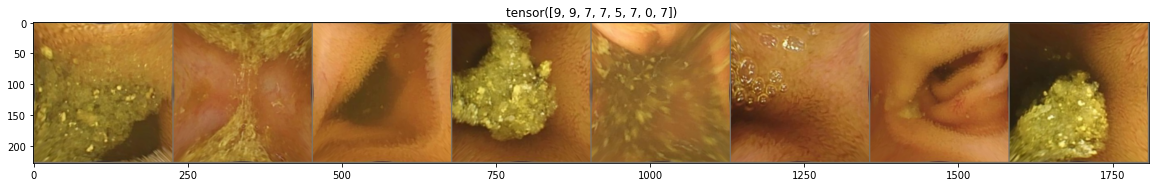

In [14]:
inputs, classes = next(iter(valid_dl))
inputs, classes = inputs[:8,:,:], classes[:8]
out = torchvision.utils.make_grid(inputs)
show_batch(out, title=classes)

In [15]:
# model

In [16]:
input_tensor = inputs[0,:,:,:].unsqueeze(dim=0)
input_tensor.shape

torch.Size([1, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


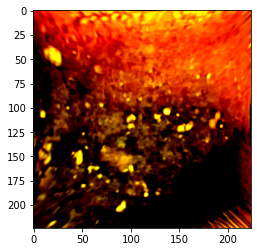

In [17]:
plt.imshow(input_tensor[0,:,:,:].permute(1,2,0).numpy())

In [18]:
import timm
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
model_swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes = 11)

C:\Users\Admin\anaconda3\envs\cls\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\swin_tiny_patch4_window7_224.pth


In [28]:
# timm.list_models()

In [23]:
model_cnn = timm.create_model('resnet18', pretrained = False, num_classes = 11)

In [24]:
model_cnn

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [25]:
crop_model = torch.nn.Sequential(*(list(model_cnn.children())[:-1]))

In [26]:
crop_model(inputs).shape

torch.Size([8, 512])

In [ ]:
a = crop_model(inputs)
b = crop_model(inputs)

In [ ]:
torch.flatten(torch.cat((a,b),dim=1),1).shape

In [ ]:
a.shape